In [1]:
import pandas as pd
from datetime import datetime

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

In [3]:
from src.config.config import *
from src.models.wgan import *
from src.attributes import *

## Setup

In [4]:
models = pd.read_csv(path_models + 'model_stats.csv')

In [5]:
models

,Id,Model,Img_size,Batch_size,Epochs,Num_gen,Date,Time


In [6]:
#model_id = create_model_id(models)
model_id = '43833e'
model_type = 'wgan'

In [12]:
setup_data_directory (model_id, model_type, ['generated_masks'])

In [13]:
setup_models_directory(model_type, ['generator', 'critic'])

### Look at training data

In [7]:
training_data = pd.read_csv(path_trainingset)

In [8]:
training_data.head()

,Image,Mask,is_validation
0,ISIC_0013678.jpg,ISIC_0013678_segmentation.png,True
1,ISIC_0014610.jpg,ISIC_0014610_segmentation.png,True
2,ISIC_0011149.jpg,ISIC_0011149_segmentation.png,True
3,ISIC_0000493.jpg,ISIC_0000493_segmentation.png,False
4,ISIC_0001449.jpg,ISIC_0001449_segmentation.png,False


## Generate masks

#### Create databunch

In [9]:
data = (GANItemList.from_df(path=path_mask, df=training_data.drop(['Image', 'is_validation'], axis = 1), noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=None, size=128, tfm_y=True)
               .databunch(bs=128)
               .normalize(stats = [torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5])], do_x=False, do_y=True))

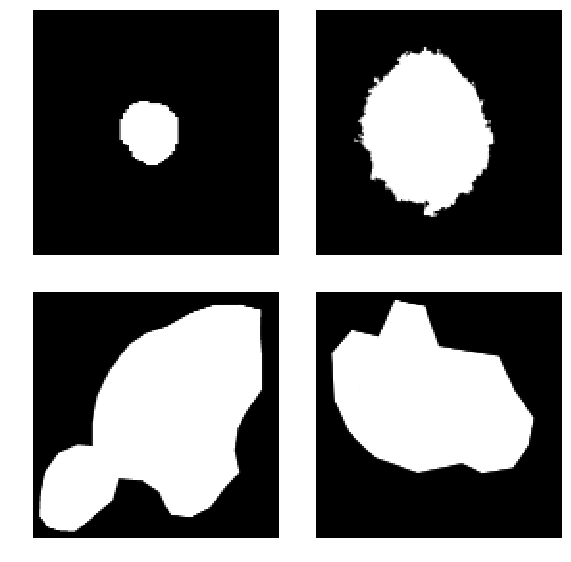

In [6]:
data.show_batch(rows=2)

#### Create the GAN model

In [7]:
generator = basic_generator(in_size=img_size, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=img_size, n_channels=3, n_extra_layers=1)

In [11]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                    opt_func = partial(optim.Adam, betas = (0., 0.99)), wd=0.)

#### Train the GAN model

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.061041,#na#,-0.001470,-0.070049,02:34
1,-0.054580,#na#,-0.008352,-0.065861,02:32
2,-0.040592,#na#,0.023876,-0.057169,02:34
3,-0.033916,#na#,0.032780,-0.049258,02:28
4,-0.036227,#na#,0.002733,-0.043441,02:35
5,-0.053327,#na#,-0.015939,-0.056482,02:32
6,-0.042903,#na#,-0.009429,-0.048329,02:31
7,-0.041245,#na#,-0.005153,-0.048414,02:30
8,-0.048789,#na#,-0.017841,-0.051604,02:34
9,-0.043002,#na#,-0.023539,-0.043689,02:31


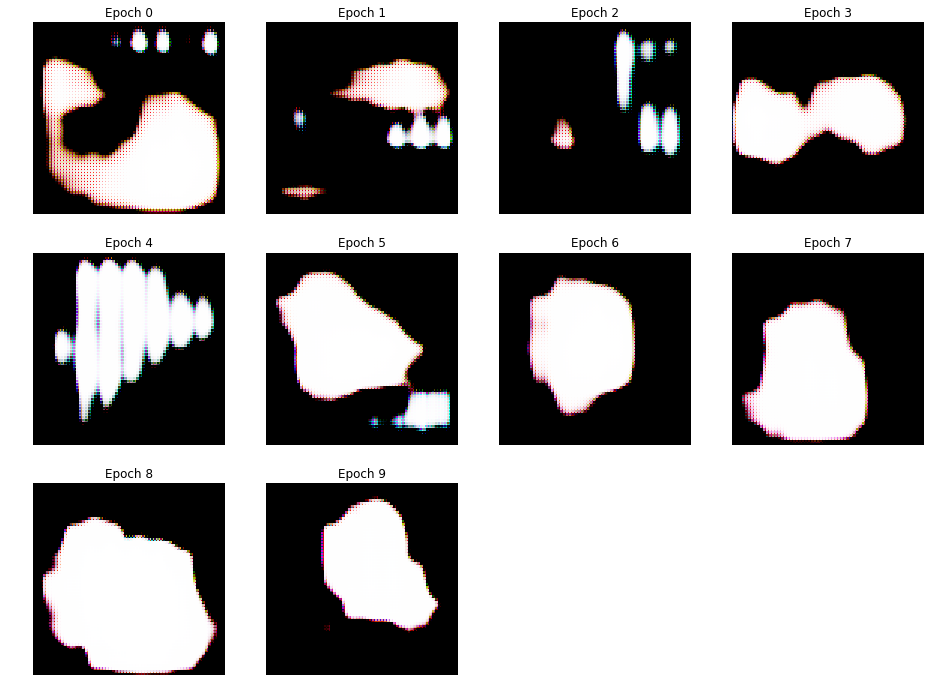

In [28]:
learn.fit(30 ,2e-2)

Save model

In [1]:
torch.save(generator, path_models + '/generator/' + model_type + '/' + model_id + '.pth')
torch.save(critic.state_dict(), path_models + '/critic/' + model_type + '/' + model_id + '.pth')


Load model

In [11]:
generator = torch.load(path_models + '/generator/' + model_type + '/' + model_id + '.pth')
generator.to("cuda")
critic.load_state_dict(torch.load(path_models + '/critic/' + model_type + '/' + model_id + '.pth'))
critic.to("cuda")
print()

AssertionError: Torch not compiled with CUDA enabled

#### Save predictions

In [12]:
save_pred(generator, path_gen + '/generated_masks/' + model_type + '/' + model_id, 3000)

#### Clean images

In [7]:
image_cleaner(path_gen + '/generated_masks/'+ model_type + '/' + model_id)

#### Save model stats

In [42]:
models

,Id,Model,Img_size,Batch_size,Epochs,Num_gen,Date,Time
0,4383e,wgan,128,128,100,100,08/10/2019,12:00:41


In [43]:
date = datetime.now().strftime("%d/%m/%Y")
time = datetime.now().strftime("%H:%M:%S")

In [44]:
model_stats = pd.DataFrame({'Id': [model_id], 'Model': model_type, 'Img_size': img_size, 'Batch_size': batch_size, 'Epochs': epochs, 'Num_gen': num_gen_mask, 'Date': date, 'Time' : time})

In [45]:
models = add_model_stats(model_stats, models)

overwrite=False. Set overwrite to True if you want to delete old model


In [46]:
models

,Id,Model,Img_size,Batch_size,Epochs,Num_gen,Date,Time
0,4383e,wgan,128,128,100,100,08/10/2019,12:00:41


In [47]:
add_model_stats(model_stats, models, overwrite=True)

,Id,Model,Img_size,Batch_size,Epochs,Num_gen,Date,Time
0,4383e,wgan,128,128,100,100,08/10/2019,12:09:47


In [51]:
n = '1'
n.zfill(4)

'0001'

In [12]:
import torch; torch.rand(1).cuda() 

AssertionError: Torch not compiled with CUDA enabled